# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package

!pip install smdebug
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 881.9 MB 2.6 kB/s             
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 23.3 MB 21.5 MB/s            
     |████████████████████████████████| 881.9 MB 3.1 kB/s             6.1 MB/s eta 0:00:066.1 MB/s eta 0:00:06
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import torch
import os
import io
import pandas as pd
import numpy as np
import sagemaker
import boto3
import matplotlib.pyplot as plt
import IPython

from sagemaker import get_execution_role
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import (Rule, ProfilerRule, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig,
rule_configs)
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.io import read_image
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from mpl_toolkits.axes_grid1 import host_subplot
from PIL import Image

Matplotlib is building the font cache; this may take a moment.


[2022-02-20 06:57:59.070 ip-172-16-136-152.ec2.internal:11901 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

The dataset I'm using for this project is a set of dog images. There are three different datasets: train, test and validation. These datasets are divided by breeds and these will be the classes for the classification model.

In [12]:
# # Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-02-13 19:05:50--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.208
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 8.45MB/s   in 2m 17s 

2022-02-13 19:08:07 (7.86 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [54]:
#TODO: Fetch and upload the data to AWS S3
session = sagemaker.session.Session()
bucket = session.default_bucket()
role = get_execution_role()

inputs = session.upload_data(path='dogImages', bucket=bucket, key_prefix='data-project')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [55]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_range = {
    'lr': ContinuousParameter(0.001, 0.1),
    'epochs': IntegerParameter(3,10),
    'batch-size': CategoricalParameter([16,32])
}

objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [56]:
#TODO: Create estimators for your HPs

role = sagemaker.get_execution_role()

# TODO: Your estimator here
estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.2xlarge'
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_range,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=6,
    objective_type=objective_type
)

In [57]:
# TODO: Fit your HP Tuner

# TODO: Remember to include your data channels
input_data = 's3://sagemaker-us-east-1-893465915663/data-project'
tuner.fit(
    {
    'train': input_data + '/train',
    'test': input_data + '/test',
    'val': input_data + '/valid'
    }
 ) 



.......................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [58]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-02-20 03:12:18 Starting - Preparing the instances for training
2022-02-20 03:12:18 Downloading - Downloading input data
2022-02-20 03:12:18 Training - Training image download completed. Training in progress.
2022-02-20 03:12:18 Uploading - Uploading generated training model
2022-02-20 03:12:18 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '5',
 'lr': '0.013340094864592396',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-02-20-02-54-48-276"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-02-54-48-276/source/sourcedir.tar.gz"'}

In [90]:
best_estimator._current_job_name

'pytorch-training-220220-0254-003-ee14521d'

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [69]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))

collection_configs = [
    CollectionConfig(
        name="custom_losses",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "100",
            "eval.save_interval": "10"
        }
    )
]

hook_config = DebuggerHookConfig(
    collection_configs=collection_configs
)


In [70]:
# TODO: Create and fit an estimator

# These hyperparameters were not called by best_estimator.hyperparameters()['name_of_hyperparameter'] because if that 
# variable definition method was used, I would have to run hyperparameter optimization everytime I'd like to create the 
# next estimator, and that certainly would be enough to deplete my AWS credits. Therefore, I extracted the best hyper-
# parameters on the previous cells and manually input them when creating my estimator.

batch_size = int(best_estimator.hyperparameters()['batch-size'][1:3])
epochs = int(best_estimator.hyperparameters()['epochs'])
lr = float(best_estimator.hyperparameters()['lr'])

# batch_size = 32
# epochs = 5
# lr = 0.013340094
hyperparameters = {'batch-size':batch_size, 'epochs': epochs, 'lr': lr}

estimator = PyTorch(
    entry_point = 'train_model.py',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    hyperparameters=hyperparameters,
    framework_version='1.8',
    py_version='py36',
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
    )

In [71]:
input_data = 's3://sagemaker-us-east-1-893465915663/data-project'
estimator.fit(
    {
    'train': input_data + '/train',
    'test': input_data + '/test',
    'val': input_data + '/valid'
    },
 )

2022-02-20 03:52:37 Starting - Starting the training job...
2022-02-20 03:53:01 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-20 03:54:08 Starting - Preparing the instances for training......
2022-02-20 03:55:05 Downloading - Downloading input data.........
2022-02-20 03:56:39 Training - Downloading the training image...............
2022-02-20 03:59:10 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-20 03:59:10,548 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-20 03:59:10,569 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-20 03:59:16,797 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-20 03:59:17,319 sagemaker-tra

In [74]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
region = session.boto_region_name

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-02-20 04:11:13.522 ip-172-16-157-129.ec2.internal:14549 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/debug-output
[2022-02-20 04:11:16.330 ip-172-16-157-129.ec2.internal:14549 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-20 04:11:17.357 ip-172-16-157-129.ec2.internal:14549 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0']

In [75]:
trial.tensor('CrossEntropyLoss_output_0').values()

{0: array(4.8650985, dtype=float32),
 100: array(3.6788666, dtype=float32),
 200: array(2.0547504, dtype=float32),
 209: array(2.340231, dtype=float32),
 219: array(1.2442166, dtype=float32),
 229: array(2.0488272, dtype=float32),
 239: array(2.1331663, dtype=float32),
 249: array(1.5031624, dtype=float32),
 259: array(3.4706955, dtype=float32),
 269: array(1.8015835, dtype=float32),
 279: array(2.7562895, dtype=float32),
 289: array(2.55315, dtype=float32),
 384: array(1.7099278, dtype=float32),
 484: array(1.1459041, dtype=float32),
 508: array(1.9238112, dtype=float32),
 518: array(0.61248875, dtype=float32),
 528: array(1.1655216, dtype=float32),
 538: array(1.2619363, dtype=float32),
 548: array(0.766336, dtype=float32),
 558: array(1.4910656, dtype=float32),
 568: array(2.0154376, dtype=float32),
 578: array(1.8609924, dtype=float32),
 668: array(0.9052928, dtype=float32),
 768: array(1.2317564, dtype=float32),
 797: array(0.80261075, dtype=float32),
 807: array(0.9271021, dtype=

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


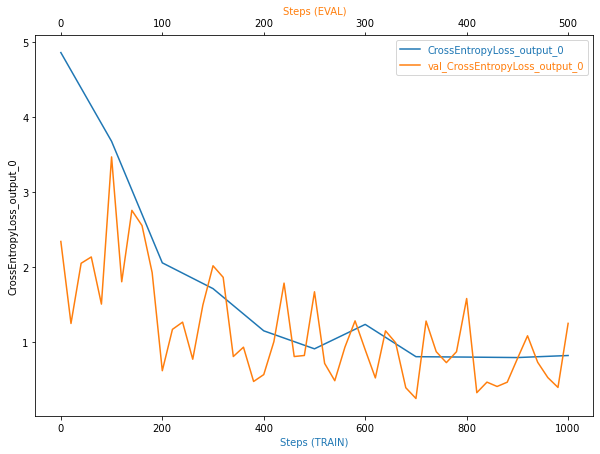

In [76]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

A strange behaviour was observed with the debugger output during the preparations runs. For these runs, I set the number of epochs to 1 (one) in order to reduce AWS instance costs.
Initially, the output had a length of 1 (one) and its value was 0 (zero). That means that the hook save_intervals configuration was too big to properly observe and capture the tensors being generated by the training script.
This was corrected by the reduction of the save_intervals and increase of epochs.

In [77]:
# TODO: Display the profiler output
tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-893465915663/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/profiler-output


Profiler data from system is available


In [78]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=['CPU','GPU'],
    select_events=['total'],
)

[2022-02-20 04:11:28.620 ip-172-16-157-129.ec2.internal:14549 INFO metrics_reader_base.py:134] Getting 16 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [79]:
rule_output_path = estimator.output_path + estimator.latest_training_job.name + '/rule-output'
print(rule_output_path)

s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/rule-output


In [80]:
!aws s3 ls {rule_output_path} --recursive 

2022-02-20 04:10:35     436631 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-20 04:10:35     295362 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-20 04:10:30        559 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-20 04:10:30      22034 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-20 04:10:30       2077 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-20 04:10:30        327 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-20 04:10:30       5236 pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-re

In [81]:
!aws s3 cp {rule_output_path} ./ --recursive 

download: s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36

In [82]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [83]:
IPython.display.HTML(filename=profiler_report_name + '/profiler-output/profiler-report.html')

## Model Deploying

In [4]:
jpeg_serializer = IdentitySerializer("image/jpeg")
json_deserializer = JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [5]:
# # TODO: Run an prediction on the endpoint

#  # TODO: Your code to load and preprocess image to send to endpoint for prediction

role = get_execution_role()
# model_location = estimator.model_data
model_location = 's3://sagemaker-us-east-1-893465915663/pytorch-training-2022-02-20-03-52-36-847/output/model.tar.gz'

pytorch_model = PyTorchModel(
    model_data=model_location,
    role = role,
    entry_point='inference.py',
    py_version='py36',
    framework_version='1.8',
    predictor_cls=ImagePredictor)

In [6]:
# TODO: Deploy your model to an endpoint

# TODO: Add your deployment configuration like instance type and number of instance

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
)

------!

The dog photo used to do the prediction is:


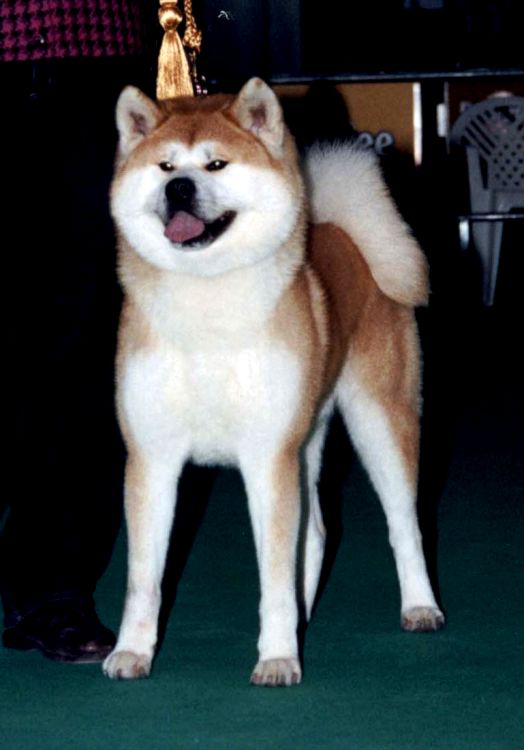

The label of the image is 4
The prediction given by the machine learning model is 4

The dog photo used to do the prediction is:


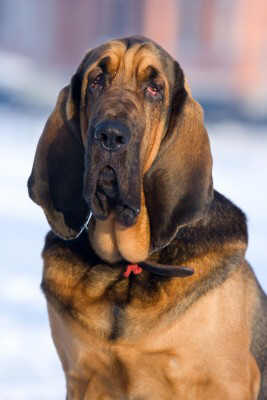

The label of the image is 27
The prediction given by the machine learning model is 27

The dog photo used to do the prediction is:


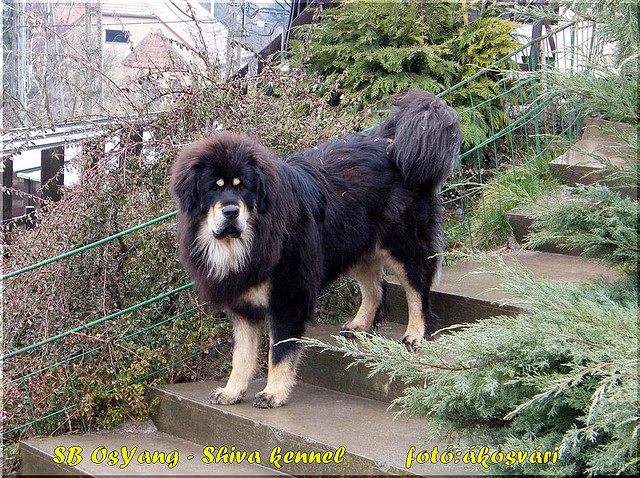

The label of the image is 129
The prediction given by the machine learning model is 129

The dog photo used to do the prediction is:


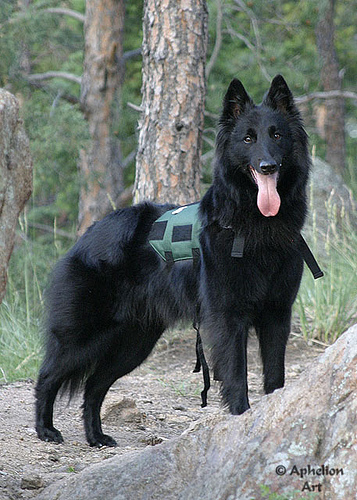

The label of the image is 21
The prediction given by the machine learning model is 21



In [97]:
# TODO: Run an prediction on the endpoint
files = [
    'dogImages/test/004.Akita/Akita_00296.jpg', 
    'dogImages/test/027.Bloodhound/Bloodhound_01871.jpg',
    'dogImages/test/129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg',
    'dogImages/test/021.Belgian_sheepdog/Belgian_sheepdog_01482.jpg'
    ]
    
for file in files:
    # Getting labels
    target_str = 'test/'
    in_pos = file.index(target_str) + len(target_str)
    label = int(file[in_pos:in_pos+3])
    
    # Displaying image to be predicted
    img = Image.open(file)
    print('The dog photo used to do the prediction is:')
    display(img)
    
    image_bytes = open(file, 'rb').read()
    response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1    
    
    print(f'The label of the image is {label}')
    print(f'The prediction given by the machine learning model is {prediction}\n')

In [112]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()